In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
_base_location = r'/Users/rahuladlakha/Documents/Github/Kaggle/Course/ts-course-data/'

In [9]:
df = pd.read_csv(_base_location+'/book_sales.csv', index_col='Date', parse_dates=['Date']).drop('Paperback', axis=1)

In [10]:
df.head()

,Hardcover
Date,
2000-04-01,139
2000-04-02,128
2000-04-03,172
2000-04-04,139
2000-04-05,191


The linear regression algorithm learns how to make a weighted sum from its input features

target = weight_1 * feature_1 + weight_2 * feature_2 + bias

The regression algorithm learns values for the parameters weight_1, weight_2, and bias that best fit the target. (This algorithm is often called ordinary least squares since it chooses values that minimize the squared error between the target and the predictions.) The weights are also called regression coefficients and the bias is also called the intercept because it tells you where the graph of this function crosses the y-axis.

#### Time Step Feature

There are two kinds of features unique to time series: time-step features and lag features.

Time-step features are features we can derive directly from the time index. The most basic time-step feature is the time dummy, which counts off time steps in the series from beginning to end.

In [11]:
df['Time'] = np.arange(len(df.index))

df.head()

,Hardcover,Time
Date,,
2000-04-01,139,0
2000-04-02,128,1
2000-04-03,172,2
2000-04-04,139,3
2000-04-05,191,4


Linear regression with the time dummy produces the model:

target = weight * time + bias

The time dummy then lets us fit curves to time series in a time plot, where Time forms the x-axis.

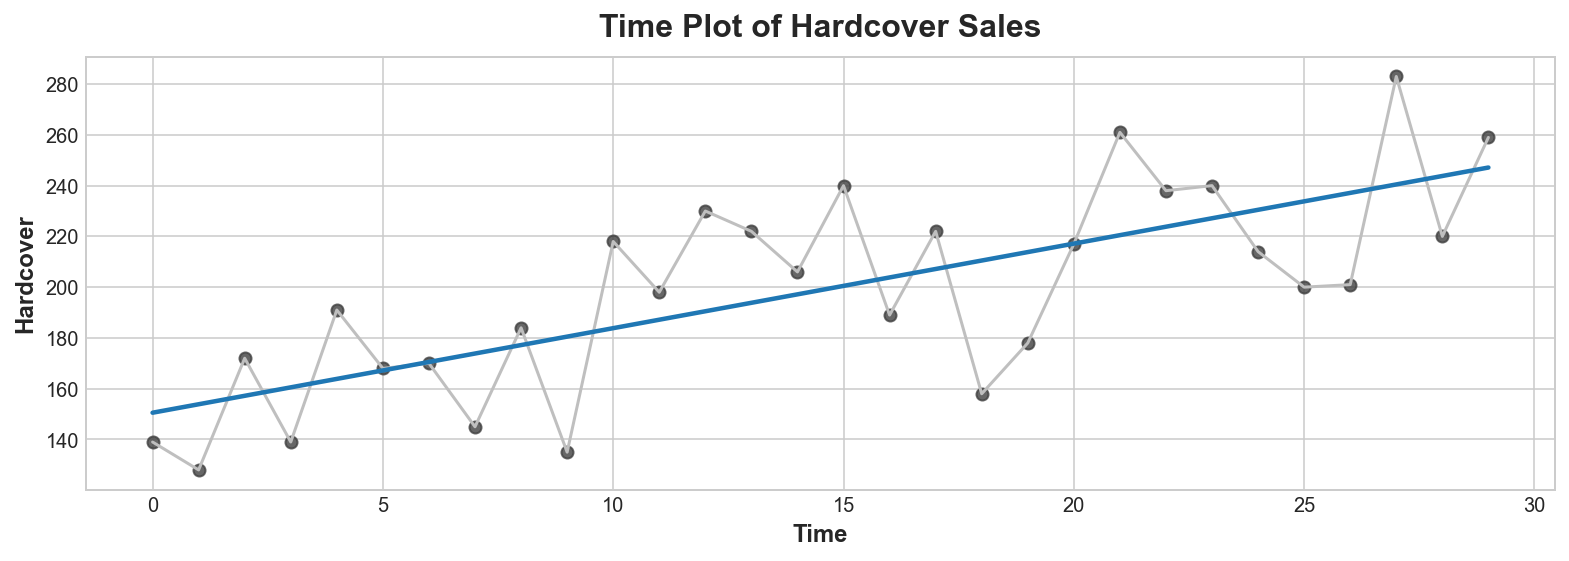

In [12]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=df, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

Time-step features let you model time dependence. A series is time dependent if its values can be predicted from the time they occured. In the Hardcover Sales series, we can predict that sales later in the month are generally higher than sales earlier in the month.

#### Lag Features

To make a lag feature we shift the observations of the target series so that they appear to have occured later in time. 

Here we've created a 1-step lag feature, though shifting by multiple steps is possible too.

In [13]:
df['Lag_1'] = df['Hardcover'].shift(1)
df = df.reindex(columns=['Hardcover', 'Lag_1'])

df.head()

,Hardcover,Lag_1
Date,,
2000-04-01,139,NaN
2000-04-02,128,139.0
2000-04-03,172,128.0
2000-04-04,139,172.0
2000-04-05,191,139.0


Linear regression with a lag feature produces the model:

target = weight * lag + bias

So lag features let us fit curves to lag plots where each observation in a series is plotted against the previous observation.

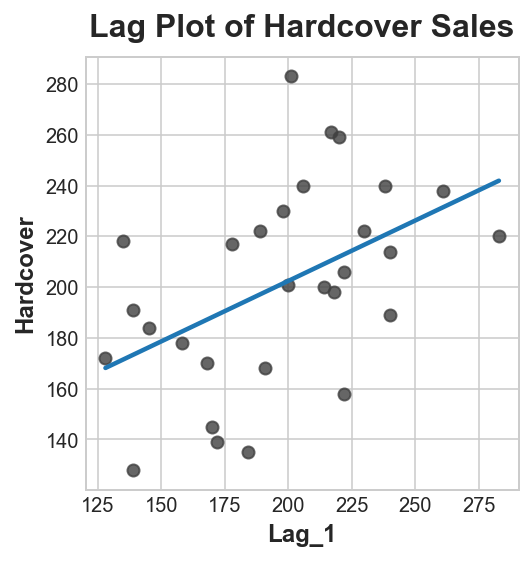

In [14]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales');

You can see from the lag plot that sales on one day (Hardcover) are correlated with sales from the previous day (Lag_1). When you see a relationship like this, you know a lag feature will be useful.

More generally, lag features let you model serial dependence. A time series has serial dependence when an observation can be predicted from previous observations. In Hardcover Sales, we can predict that high sales on one day usually mean high sales the next day.

In [15]:
tunnel = pd.read_csv(_base_location+'/tunnel.csv', index_col='Day', parse_dates=['Day'])

In [16]:
tunnel=tunnel.to_period()

In [17]:
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


Provided the time series doesn't have any missing dates, we can create a time dummy by counting out the length of the series.

In [18]:
df = tunnel.copy()

df['Time'] = np.arange(len(tunnel.index))

df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


In [19]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'NumVehicles']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

In [20]:
model.intercept_

98176.20634409295

In [21]:
model.coef_

array([22.49744953])

The model actually created is (approximately): Vehicles = 22.5 * Time + 98176

In [22]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

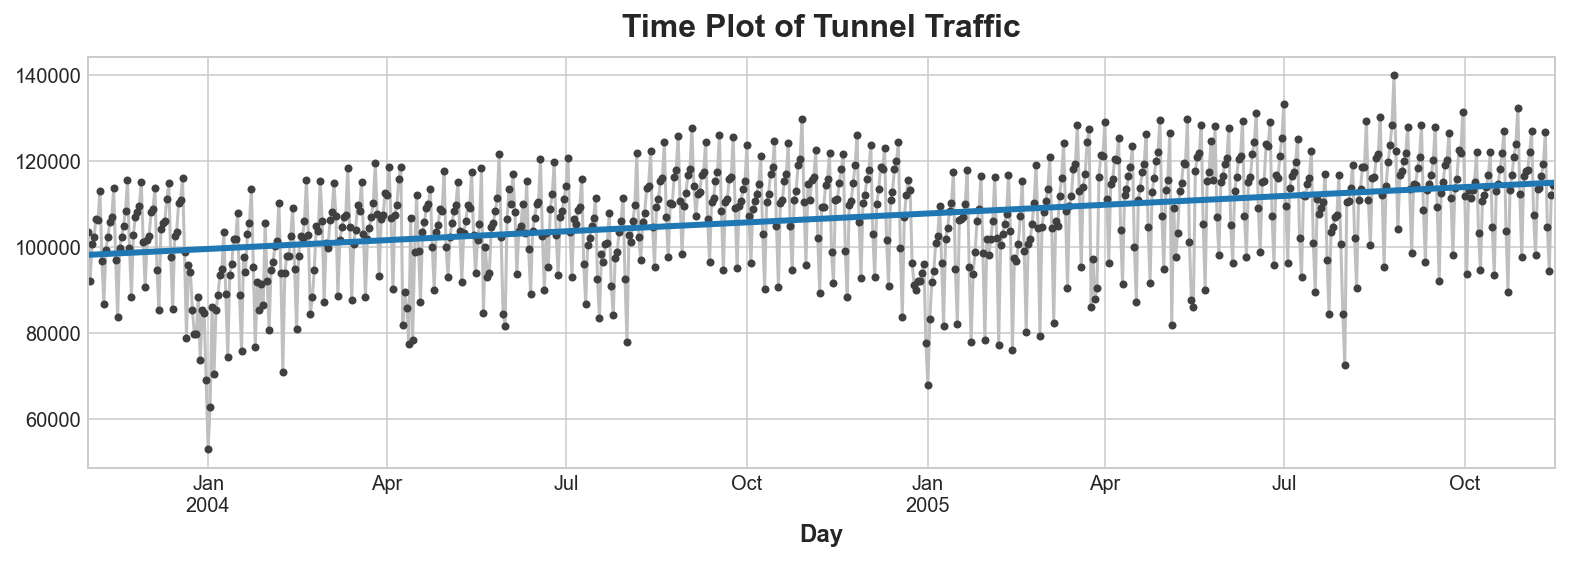

In [23]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

In [24]:
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


When creating lag features, we need to decide what to do with the missing values produced. 

Filling them in is one option, maybe with 0.0 or "backfilling" with the first known value. Instead, we'll just drop the missing values, making sure to also drop values in the target from corresponding dates.

In [25]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'NumVehicles']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

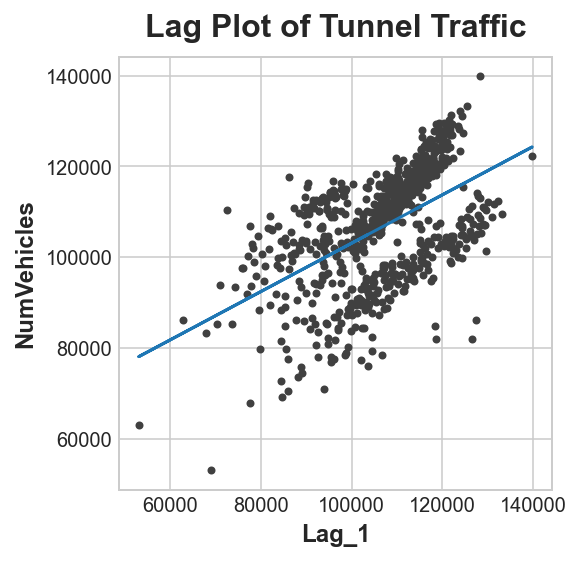

In [26]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');

What does this prediction from a lag feature mean about how well we can predict the series across time? 

The following time plot shows us how our forecasts now respond to the behavior of the series in the recent past

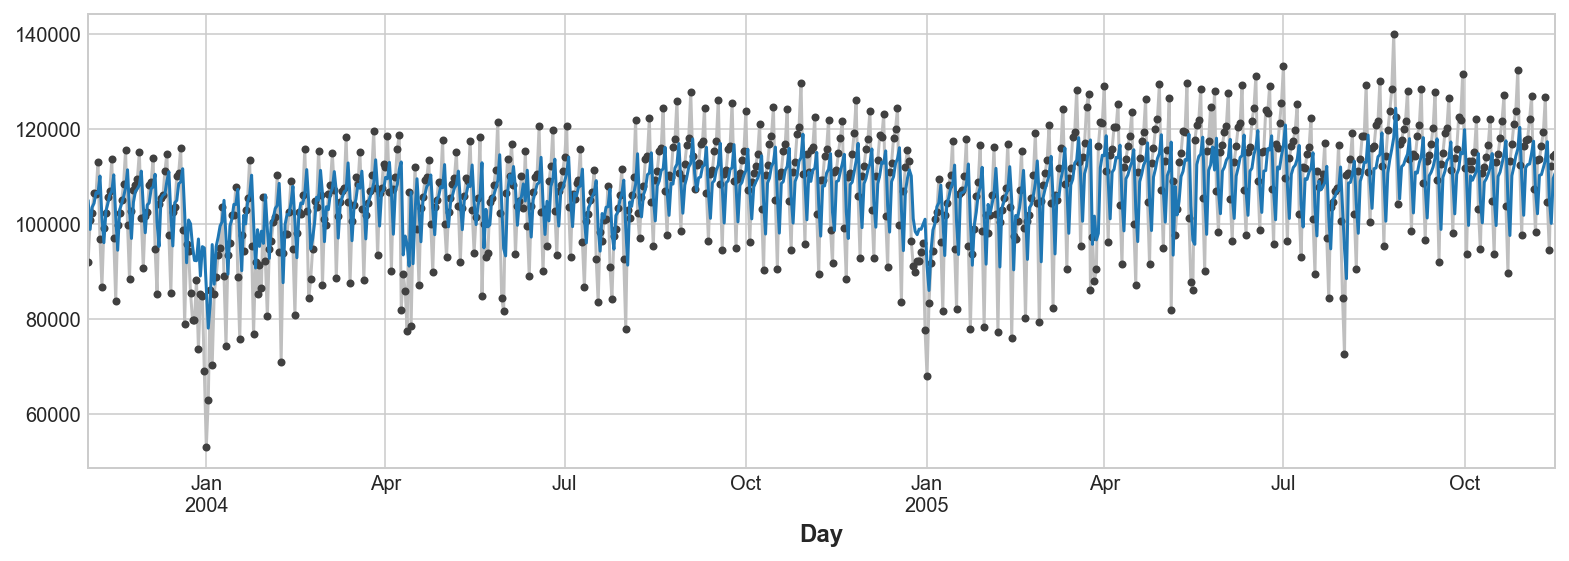

In [27]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

## Trends

The trend component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance. 

In a time series of product sales, an increasing trend might be the effect of a market expansion as more people become aware of the product year by year.

We mostly focus on trends in the mean. More generally though, any persistent and slow-moving change in a series could constitute a trend -- time series commonly have trends in their variation for instance.

### Moving Average Plots

To see what kind of trend a time series might have, we can use a moving average plot. To compute a moving average of a time series, we compute the average of the values within a sliding window of some defined width. 

Each point on the graph represents the average of all the values in the series that fall within the window on either side. The idea is to smooth out any short-term fluctuations in the series so that only long-term changes remain.

If a series has a repeating up and down movement year after year -- a short-term, seasonal change. For a change to be a part of the trend, it should occur over a longer period than any seasonal changes. To visualize a trend, therefore, we take an average over a period longer than any seasonal period in the series.

Once we've identified the shape of the trend, we can attempt to model it using a time-step feature. We've already seen how using the time dummy itself will model a linear trend:

target = a * time + b

We can fit many other kinds of trend through transformations of the time dummy. If the trend appears to be quadratic (a parabola), we just need to add the square of the time dummy to the feature set, giving us

target = a * time ** 2 + b * time + c

Linear regression will learn the coefficients a, b, and c.

The trend curves in the figure below were both fit using these kinds of features and scikit-learn's LinearRegression

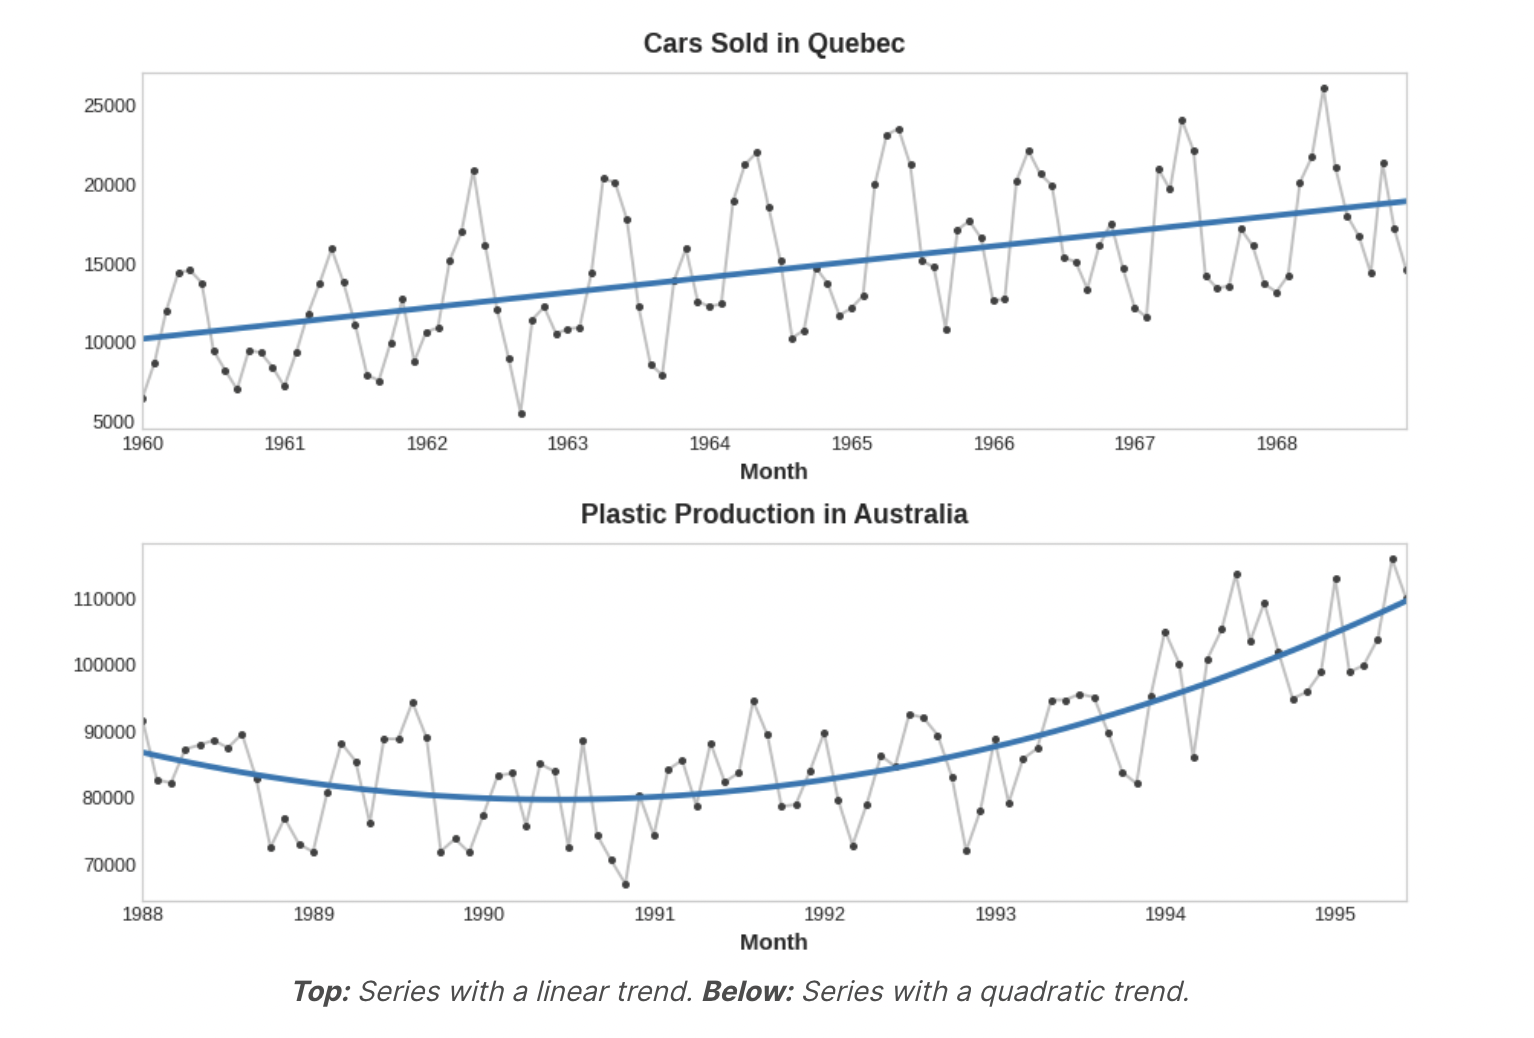

In [28]:
from IPython.display import Image
Image(filename="/Users/rahuladlakha/Documents/trend.png")

If you haven't seen the trick before, you may not have realized that linear regression can fit curves other than lines. The idea is that if you can provide curves of the appropriate shape as features, then linear regression can learn how to combine them in the way that best fits the target.

In [29]:
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


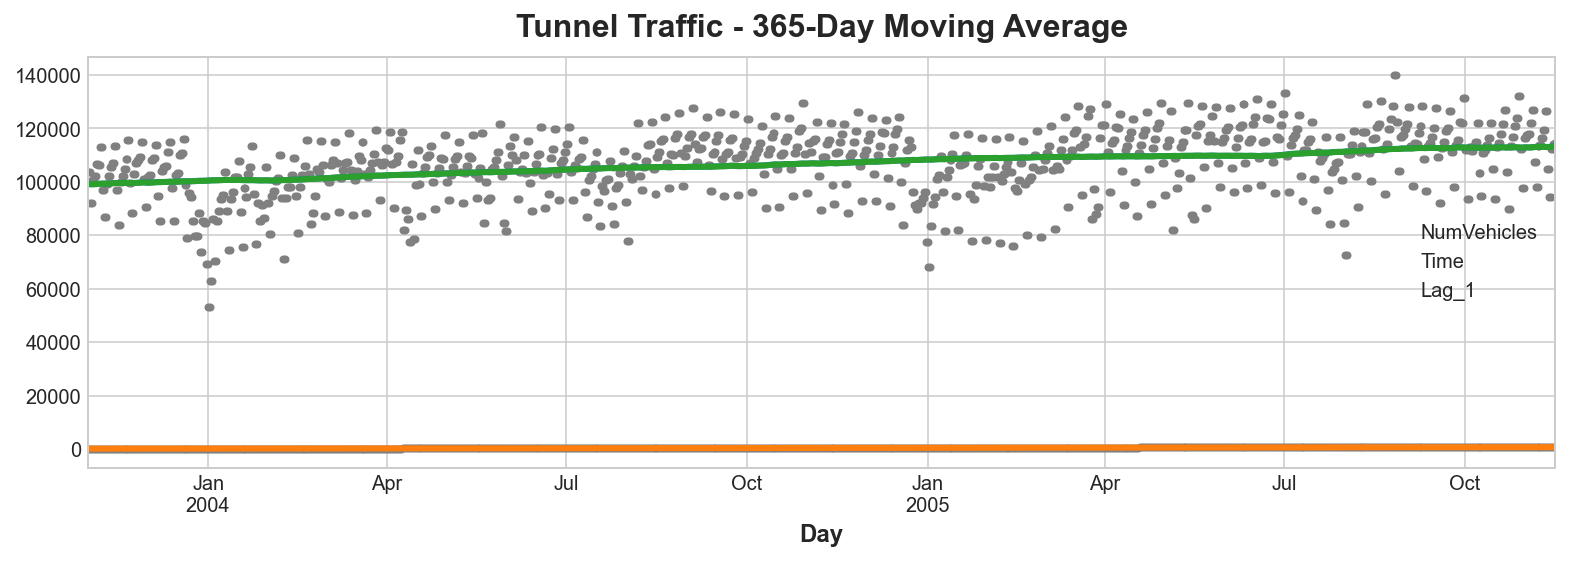

In [30]:
moving_average = df.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = df.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

We'll use a function from the statsmodels library called DeterministicProcess. 

Using this function will help us avoid some tricky failure cases that can arise with time series and linear regression. The order argument refers to polynomial order: 1 for linear, 2 for quadratic, 3 for cubic, and so on

In [31]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


A deterministic process, by the way, is a technical term for a time series that is non-random or completely determined, like the const and trend series are. Features derived from the time index will generally be deterministic

In [32]:
from sklearn.linear_model import LinearRegression

y = tunnel["NumVehicles"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

The trend discovered by our LinearRegression model is almost identical to the moving average plot, which suggests that a linear trend was the right decision in this case.

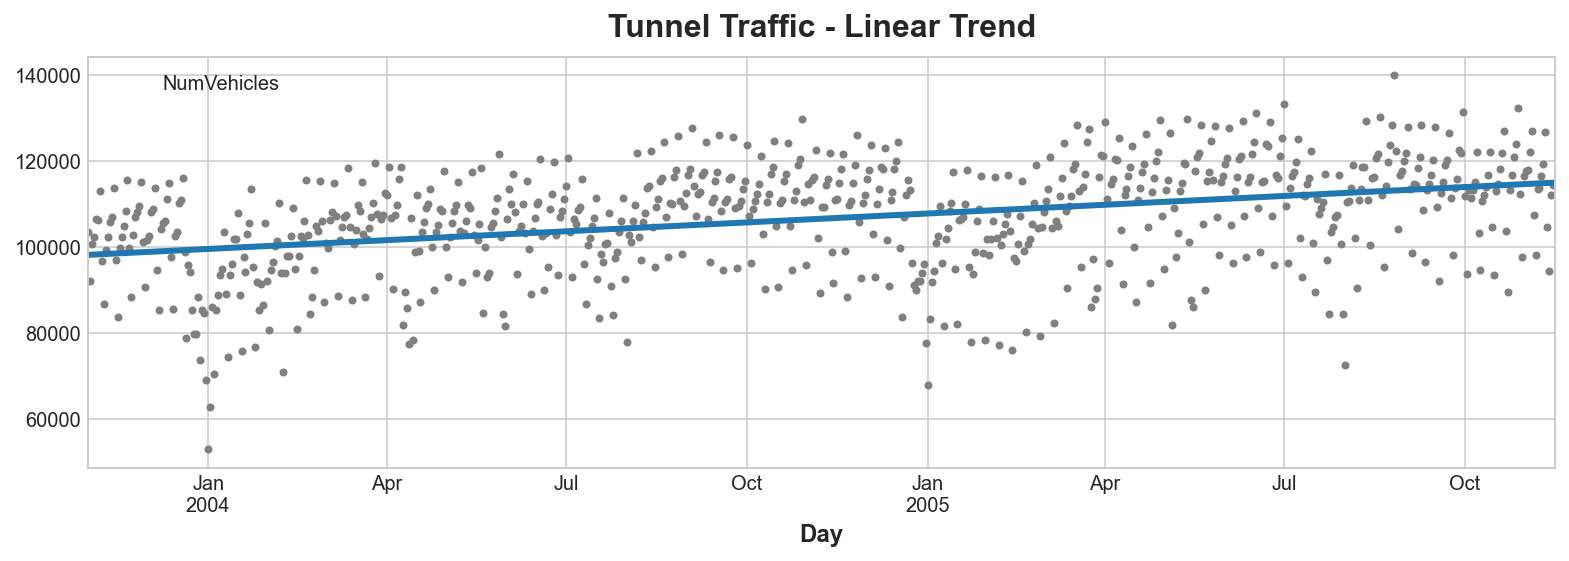

In [33]:
ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")


In [34]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

Let's plot a portion of the series to see the trend forecast for the next 30 days:

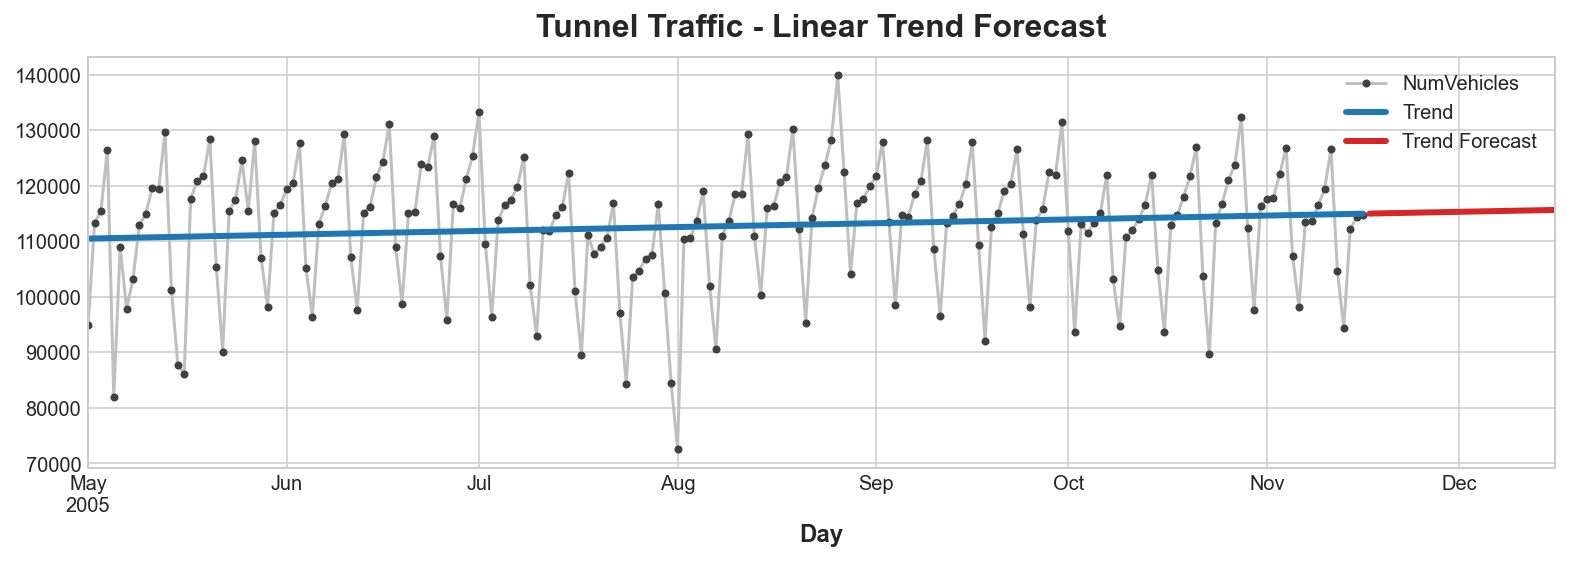

In [35]:
ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

## Seasonality

We say that a time series exhibits seasonality whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. 

Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times.

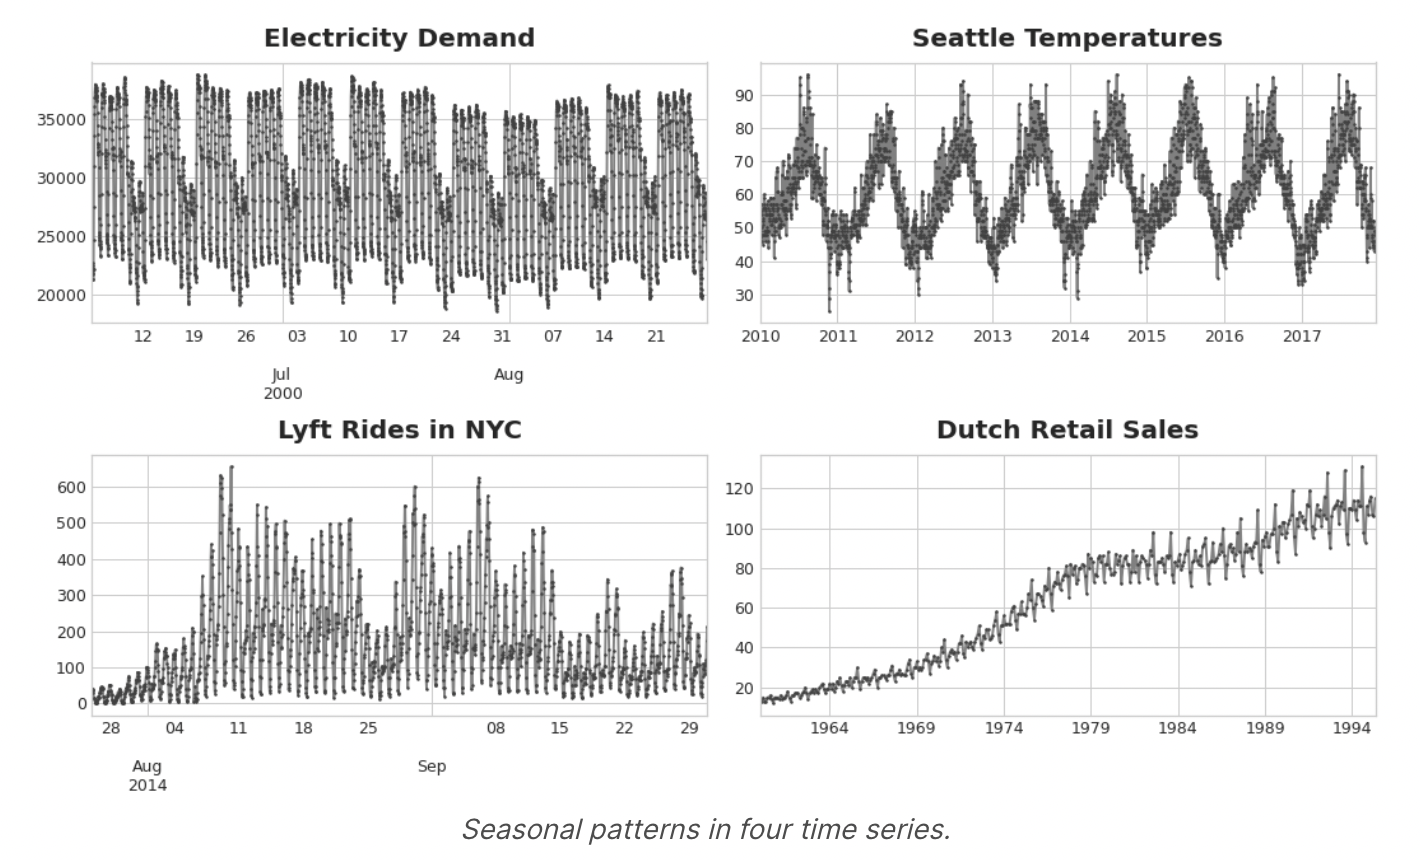

In [36]:
from IPython.display import Image
Image(filename="/Users/rahuladlakha/Documents/seasonality.png")

We will learn two kinds of features that model seasonality. The first kind, indicators, is best for a season with few observations, like a weekly season of daily observations. 

The second kind, Fourier features, is best for a season with many observations, like an annual season of daily observations.

### Seasonal Plots and Seasonal Indicators

Just like we used a moving average plot to discover the trend in a series, we can use a seasonal plot to discover seasonal patterns.

A seasonal plot shows segments of the time series plotted against some common period, the period being the "season" you want to observe. The figure shows a seasonal plot of the daily views of Wikipedia's article on Trigonometry: the article's daily views plotted over a common weekly period.

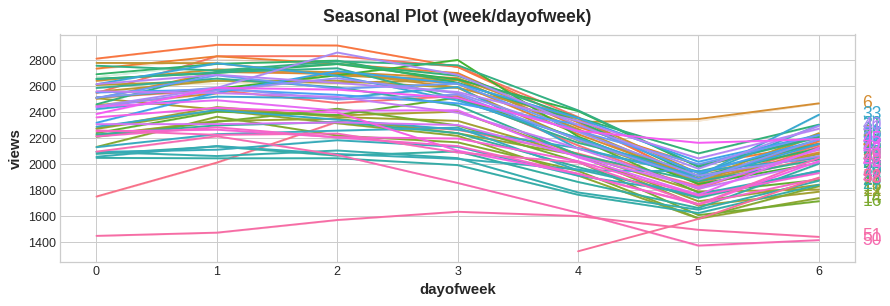

In [37]:
from IPython.display import Image
Image(filename="/Users/rahuladlakha/Documents/seasonal_plot.png")

### Seasonal indicators

Seasonal indicators are binary features that represent seasonal differences in the level of a time series. Seasonal indicators are what you get if you treat a seasonal period as a categorical feature and apply one-hot encoding.

By one-hot encoding days of the week, we get weekly seasonal indicators. Creating weekly indicators for the Trigonometry series will then give us six new "dummy" features. (Linear regression works best if you drop one of the indicators; we chose Monday in the frame below.)